# General Price Prediction Model: Ames, Iowa

This notebook will encompass pre-processing, feature engineering, and modeling with the data from the 01_EDA_and_Cleaning notebook.  There are some features containing ordinal data that will need to be treated. Data will also need to be transformed and/or scaled for some of the various models.

The focus here is on the general price prediction models that will be used to predict values for the Kaggle competition submission.  There are a large amount of features so I'm expecting the more basic regression models to yield lower performing results. Therefore, I'll also be scaling and transforming the data in order to use Lasso, Ridge, and Elastic Net models which I expect to perform better given the number of features.

The various models that are produced will be scored and then predictions will be made by one or more of those models and submitted to the Kaggle competition.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# imports for transforming, modeling, and scoring
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, \
ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# imports for q-q plots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# imports and code for warning suppression
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Import data

In [2]:
train = pd.read_csv('../data/train_cleaned.csv')
test = pd.read_csv('../data/test_cleaned.csv')

In [3]:
train.head(3)

,id,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,lot_config,land_slope,neighborhood,bldg_type,...,enclosed_porch,3ssn_porch,screen_porch,yr_sold,sale_type,saleprice,tot_baths,tot_sf,bsmt_fin_sf,bsmt_pct_fin
0,109,RL,68.0,13517,IR1,Lvl,CulDSac,Gtl,Sawyer,1Fam,...,0,0,0,2010,WD,130500,2.5,2204.0,533.0,73.517241
1,544,RL,43.0,11492,IR1,Lvl,CulDSac,Gtl,SawyerW,1Fam,...,0,0,0,2009,WD,220000,3.5,3035.0,637.0,69.769989
2,153,RL,68.0,7922,Reg,Lvl,Inside,Gtl,NAmes,1Fam,...,0,0,0,2010,WD,109000,2.0,2114.0,731.0,69.157994


In [4]:
test.head(3)

,id,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,lot_config,land_slope,neighborhood,bldg_type,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,yr_sold,sale_type,tot_baths,tot_sf,bsmt_fin_sf,bsmt_pct_fin
0,2658,RM,69.0,9142,Reg,Lvl,Inside,Gtl,OldTown,2fmCon,...,60,112,0,0,2006,WD,2.0,2948,0,0.00000
1,2718,RL,68.0,9662,IR1,Lvl,Inside,Gtl,Sawyer,Duplex,...,0,0,0,0,2006,WD,2.0,3934,0,0.00000
2,2414,RL,58.0,17104,IR1,Lvl,Inside,Gtl,Gilbert,1Fam,...,24,0,0,0,2006,New,3.5,2150,554,84.70948


## Preprocessing Quality and Condition Features

Features to convert categorical data to numeric data:
- Exterior Condition
- Exterior Quality
- Basement Condition
- Basement Quality
- Kitchen Quality
- Garage Condition
- Garage Quality

One of the things that I think will happen with one or more of the columns is that we will convert ordinal categorical values to numerical ones.  I will define a function that can take a specific dictionary of the mapping of values to numbers so that this can be applied and re-used as necessary for certain features.

In addition, I will plan on encoding some of the categorical values such as neighborhood for the model.

Pull the mapping from the data description since we'll build one dictionary per mapping needed.

The following features all have the same scale of:
- `Exter Qual` (Ordinal): Evaluates the quality of the material on the exterior 
- `Exter Cond` (Ordinal): Evaluates the present condition of the material on the exterior
- `KitchenQual` (Ordinal): Kitchen quality
- Scale:
    - Ex	Excellent
    - Gd	Good
    - TA	Average/Typical
    - Fa	Fair
    - Po	Poor

The remaining features have a different, but similar scale:
- `Bsmt Qual` (Ordinal): Evaluates the height of the basement
- `Bsmt Cond` (Ordinal): Evaluates the general condition of the basement
- `Garage Qual` (Ordinal): Garage quality
- `Garage Cond` (Ordinal): Garage condition

    - Ex	Excellent
    - Gd	Good
    - TA	Typical
    - Fa	Fair
    - Po	Poor
    - NA	No Basement/Garage
 
It appears there is basically a 5 value map and 6 value map.  Since the values are mostly shared, I can just create one mapping dictionary. 

Based on what I saw in the visualizations in the EDA, I think I'm going to create a slightly different scale.  I might want to change this during tuning. Poor and "no" values had similar effects on sale price, so I will have those values both be 0 for now.

In [5]:
# note initial modeling was doing with 0-5 scale
# adjusting this now that I've spent more time on EDA
ord_map = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,
    'Po': 0,
    'no value': 0
}

Define a function that I can use to process the columns

In [6]:
def ord_to_num(x, dict_map):
    '''fn that takes value and map in the form of a dictionary that contains 
    the possible x values as keys and the wanted substituted value as the 
    value for that key. {value: substitute value} If there is no matching key 
    for the value, then the original value will be returned.
    '''
    
    return dict_map.get(x)

Apply the mapping function to the features in both the train and test data

In [7]:
for col in ['exter_cond', 
            'exter_qual', 
            'bsmt_qual', 
            'bsmt_cond', 
            'kitchen_qual',
            'garage_cond', 
            'garage_qual']:
    train[col] = train[col].apply(lambda x: ord_to_num(x, ord_map))
    test[col] = test[col].apply(lambda x: ord_to_num(x, ord_map))

## General Price Prediction Models

### Define a Function to Calculate and Print Scores
As many models are going to be scored, compared, and tuned, defining this function to calculate the R2 score and the RMSE for a given set of y_true values and y_pred predictions.

In [8]:
# borrowed some of this from the regularlization lesson
def get_scores(y_true, y_pred):
    '''
    fn that takes y_true, y_pred then calculates and displays:
    - R2 score
    - RMSE (Root Mean Square Error)
    '''
    
    return (
        f'R2 score: {round(r2_score(y_true, y_pred), 2):.2f}',
        f'RMSE: {round(mean_squared_error(y_true, y_pred)**0.5, 2):.2f}'
    )

### Setup X, y, split, create a baseline null model

For the next few steps, we'll focus on using only the numeric columns that we currently have. We'll start by setting up just a few of the features for the Simple Linear Regression:
- bedrooms
- bathrooms
- total square feet

In [9]:
#configure X and y with features and target
X = train[['tot_baths', 'bedroom_abvgr', 'tot_sf']]
y = train['saleprice']

# split for train and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=415)

### Create Null model
To create a baseline, we'll score a null model that is only using the mean of the sale price

In [10]:
base_null = [y_train.mean()]*len(y_val)
get_scores(y_val, base_null)

('R2 score: -0.00', 'RMSE: 75342.56')

Baseline null model has a zero for R2 which means that it is not describing the variance in the target value at all.  It follows with an RMSE of approximately \$75,000 dollars.

### Simple Linear Regression

Instantiate and fit our training data to our linear regression model:

In [11]:
#instantiate model
slr = LinearRegression()

In [12]:
slr.fit(X_train, y_train)

LinearRegression()

#### Model Evaluation
In this section we will:
- Obtain the cross validation score to inform what the expected scores should be for our model on training and validation data  
- Score the model using training data getting both R2 and RMSE
- Score the model using validation data getting both R2 and RMSE
- Make predictions with the model and calculate the residuals
- Plot the residuals against the predicted values to help evaluate the model
- Check the distribution of the errors
- Generate a Q-Q plot to check normality

In [13]:
# check cross val score
cross_val_score(slr, X_train, y_train, cv=5).mean()

0.7412501724470439

Score the model on training data

In [14]:
# slr train score
get_scores(y_train, slr.predict(X_train))

('R2 score: 0.75', 'RMSE: 40611.00')

Score the model on validation data

In [15]:
# slr val score
get_scores(y_val, slr.predict(X_val))

('R2 score: 0.72', 'RMSE: 39682.87')

This simple linear regression model improved quite a bit from the baseline with the RMSE coming down ~46% from 75k dollars to 40k dollars.  This simple model is also explaining about 72% of the target variation with the features used. The R2 scores of .75 and .72 on the train and validation data are within range of the cross validation score mean of .746.

Make predictions using the simple linear regression model and calculate the residuals

In [16]:
#calculate residuals by creating predictions
preds = slr.predict(X_train)
resid = y_train - preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

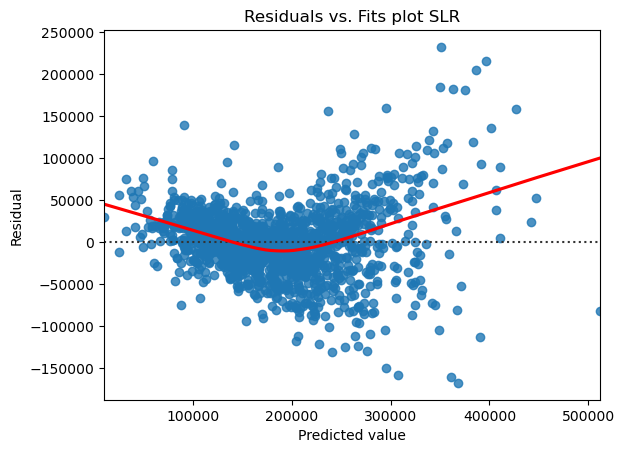

In [17]:
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot SLR',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

As the predicted value increase the error also increases in dispersion, so this model isn't explaining the data very well.  There are also some very large positive residuals, even in lower predicted values.

Checking residual/error normality

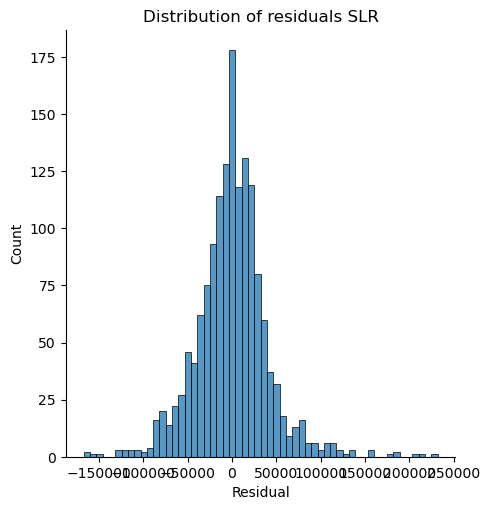

In [18]:
sns.displot(resid)\
    .set(title = 'Distribution of residuals SLR',
        xlabel = 'Residual');

The residuals do look approximately normally distributed, but it appears that there are some residuals further on the positive side of the distribution which looks like a right skew.  This matches what we were seeing in the prior residuals plot where there was a wider variance in the error as the predicted price increased, but also that there were large positive residuals throughout the entire predicted value range.

Q-Q plot

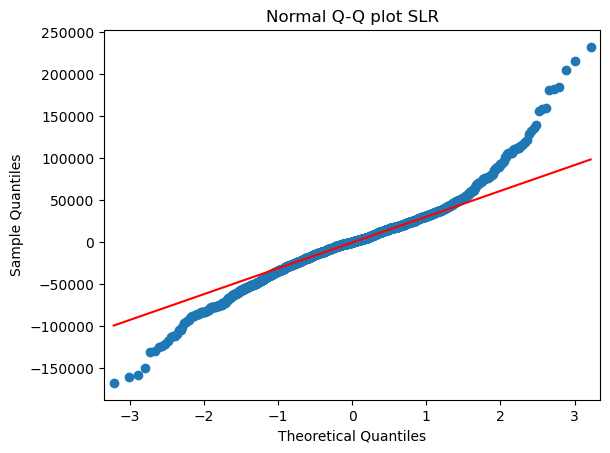

In [19]:
sm.qqplot(resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot SLR');

We see the divergence from normality in the quantiles beyond +/- 1 as we see the sample plots diverge from the normal distribution line.

### Multiple Linear Regression

From our EDA, there were some features of note that I would like to add and see how the model changes:
- overall quality
- garage area
- substitue the total square footage and include the basement and above ground features

In [20]:
#configure X and y with features and target
X = train[['tot_baths', 
             'bedroom_abvgr', 
             'total_bsmt_sf', 
             'gr_liv_area',
             'overall_qual',
             'garage_area',
            ]
         ]
y = train['saleprice']

# split for train and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=415)

Instantiate and train the model

In [21]:
#instantiate model
mlr = LinearRegression()

In [22]:
mlr.fit(X_train, y_train)

LinearRegression()

#### Model Evaluation
In this section we will:
- Obtain the cross validation score to inform what the expected scores should be for our model on training and validation data  
- Score the model using training data getting both R2 and RMSE
- Score the model using validation data getting both R2 and RMSE
- Make predictions with the model and calculate the residuals
- Plot the residuals against the predicted values to help evaluate the model
- Check the distribution of the errors
- Generate a Q-Q plot to check normality

Cross validation score

In [23]:
# check cross val score
cross_val_score(mlr, X_train, y_train, cv=5).mean()

0.8277606706107965

Score the model on training data

In [24]:
# mlr train score
get_scores(y_train, mlr.predict(X_train))

('R2 score: 0.83', 'RMSE: 33127.36')

Score the model on validation data

In [25]:
# mlr val score
get_scores(y_val, mlr.predict(X_val))

('R2 score: 0.83', 'RMSE: 31394.67')

This multiple linear regression model improved on the SLR model lowering the RMSE about 8k dollars. This model is also explaining about 83% of the target variation with the features used. The R2 scores of .83 on the train and validation data are right in line with the cross validation score mean of .83.

Make predictions using the multiple linear regression model and calculate the residuals

In [26]:
#calculate residuals by creating predictions
preds = mlr.predict(X_train)
resid = y_train - preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

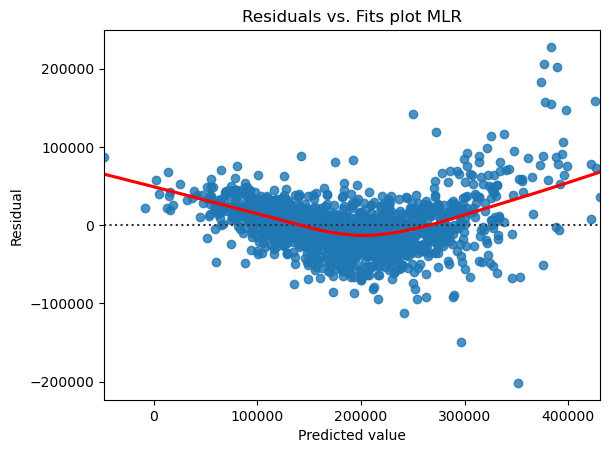

In [27]:
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot MLR',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

As the predicted value increase the error also increases in dispersion, but the spread isn't as significant as the previous model--this is an improvement over the first SLR model.

Checking residual/error normality

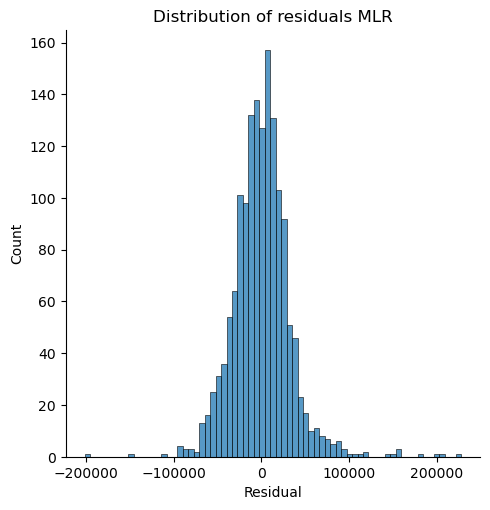

In [28]:
sns.displot(resid)\
    .set(title = 'Distribution of residuals MLR',
        xlabel = 'Residual');

This plot is showing that the right skew that we previously saw is diminishing, but not completely gone.  Another improved result using the MLR model over the SLR model.

Q-Q plot

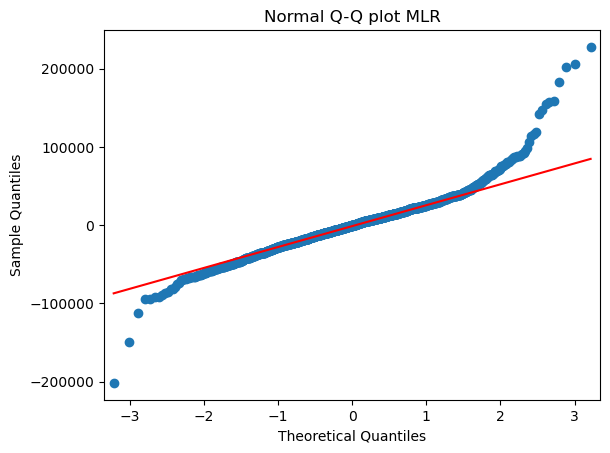

In [29]:
sm.qqplot(resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot MLR');

This q-q plot is showing that the residuals are fitting the normal distribution line much better than the SLR, which is another improvement.

### Lasso, Ridge, and Elastic Net Regularlization
Now that I've done some basic modeling with some of the numeric features, I will go back and encode the categorical features and regularlize with lasso, ridge, and elastic net methods to see how much this model can be improved.

Given the high number of features that we have in our data, I am expecting a significant improvement using these methods.

#### Re-setup the data
Set up the data and train test split using all the features available.

In [30]:
X = train.drop(['id', 'saleprice'], axis=1)
y = train['saleprice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                 random_state=415)

X_train.shape, X_val.shape, test.shape

((1636, 58), (410, 58), (878, 59))

#### Tranform the data

Here will we create a column transformer so we can one hot encode the categorical features and standardize the data with standardscaler to prepare for use with the different regularlization methods.

In [31]:
# instantiate one hot encoder
ohe = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse=False
)

# define the numeric columns
ncols = [col for col in X_train.select_dtypes(include='number') if 
            col not in ['saleprice', 'id']]

# define the categorical columns
ccols = [col for col in X_train.select_dtypes(exclude='number')]

# instantiate and configure the column transformmer
ctx = ColumnTransformer(
    transformers=[
        #('alias_first', actual_transformer, list_of_cols_to_apply_to),
        ('one_hot', ohe, ccols),
        ('ss', StandardScaler(), ncols)
        ], remainder='passthrough', # don't drop the other columns
    verbose_feature_names_out=False #don't put transformer name in front of encoded cols
)

Fit the column transformer with the training data

In [32]:
#fit the column transformer to training set
ctx.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['ms_zoning', 'lot_shape', 'land_contour',
                                  'lot_config', 'land_slope', 'neighborhood',
                                  'bldg_type', 'house_style', 'roof_style',
                                  'roof_matl', 'exterior_1st', 'exterior_2nd',
                                  'mas_vnr_type', 'foundation', 'bsmt_exposure',
                                  'bsmtfin_typ...
                                  'exter_qual', 'exter_cond', 'bsmt_qual',
                                  'bsmt_cond', 'bsmt_unf_sf', 'total_bsmt_sf',
                                  'low_qual_fin_sf', 'gr_liv_area',
                                  'bedroom_abvgr', 'kitchen_abvgr',
                                  'kitchen_qual', 'totrms_abvgrd', 'fireplaces',
                                  'garage_area', 'garage_qual', 'garage_cond',
                                  'wood_deck_sf', 'open_porch_sf',
                                  'enclosed_porch', '3ssn_porch',
                                  'screen_porch', 'yr_sold', 'tot_baths',
                                  'tot_sf', ...])],
                  verbose_feature_names_out=False)

Transform the train and validation data

In [33]:
#transform the training data
X_train_tx = ctx.transform(X_train)

In [34]:
#transform validation data
X_val_tx = ctx.transform(X_val)

Reassemble DataFrames

In [35]:
#recreate dataframes
X_train_tx = pd.DataFrame(X_train_tx, columns=ctx.get_feature_names_out())
X_val_tx = pd.DataFrame(X_val_tx, columns=ctx.get_feature_names_out())

In [36]:
X_train_tx.shape

(1636, 186)

Here you can see the result of encoding our features.  The number of features grew from 58 to 186!

### Transformation Effect on Linear Regression

Now that we've transformed the data, let us fit a linear regression model with all the features as a point of comparison.

In [37]:
# another lr with my newly transformed data
tx_lr = LinearRegression()

In [38]:
tx_lr.fit(X_train_tx, y_train)

LinearRegression()

In [39]:
# check cross val score
cross_val_score(tx_lr, X_train_tx, y_train, cv=5).mean()

-6.188904967836231e+21

Not surprising that with 186 features, the Cross Validation score suffers from a model that is overfit and does not handle unseen data very well.

Score the model on training data

In [40]:
# slr train score
get_scores(y_train, tx_lr.predict(X_train_tx))

('R2 score: 0.93', 'RMSE: 20515.63')

Score the model on validation data

In [41]:
# slr val score
get_scores(y_val, tx_lr.predict(X_val_tx))

('R2 score: -14448383549857280819200.00', 'RMSE: 9129257876588992.00')

You can clearly see that the model performed really well on the training data since it was fit really closely, but on the unseen validation data, the results are quite the opposite. This model has high variance.

### Lasso

Now that we have an overfit, high feature count model that isn't performing well, I'm implementing a lasso model to help with reducing features and improving performance.  We will use our transformed and scaled data and the LassoCV model to determine the best alpha value.  The Lasso method penalizes coefficients to prevent overfitting.  The alpha value is the strength of the penalty imposed.

In [42]:
# instantiate lasso cv
lasso = LassoCV(alphas = np.arange(0.001, 10, 1))

# fit it with transformed and scaled data 
# warnings are suppressed in the top level import section
lasso.fit(X_train_tx, y_train)

LassoCV(alphas=array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]))

In [43]:
# check best alpha
lasso.alpha_

9.000999999999998

#### Model Evaluation
In this section we will:
- Obtain the cross validation score to inform what the expected scores should be for our model on training and validation data  
- Score the model using training data getting both R2 and RMSE
- Score the model using validation data getting both R2 and RMSE
- Make predictions with the model and calculate the residuals
- Plot the residuals against the predicted values to help evaluate the model
- Check the distribution of the errors
- Generate a Q-Q plot to check normality

Cross validation score

In [44]:
# check cross val score
cross_val_score(lasso, X_train_tx, y_train, cv=5).mean()

0.9068533156616688

Score the model on training data

In [45]:
# lasso train score
get_scores(y_train, lasso.predict(X_train_tx))

('R2 score: 0.93', 'RMSE: 20593.45')

Score the model on validation data

In [46]:
# lasso val score
get_scores(y_val, lasso.predict(X_val_tx))

('R2 score: 0.91', 'RMSE: 22552.43')

The effect of the lasso regularlization is apparent--the R2 scores are indicating that this model is explaining about 91% of the variation in the target using the features in this model.  The RMSE has been reduced by about 9000 dollars from the MLR model.

Check to see how many coefficients were zeroed out:

In [47]:
# create a list of coefficients that are not equal to zero and check length
len([coef for coef in lasso.coef_ if coef != 0])

169

We went from 186 features to 169 so that lasso model zeroed out 17 features.

Make predictions using the lasso model and calculate the residuals

In [48]:
#calculate residuals by creating predictions
l_preds = lasso.predict(X_train_tx)
l_resid = y_train - l_preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

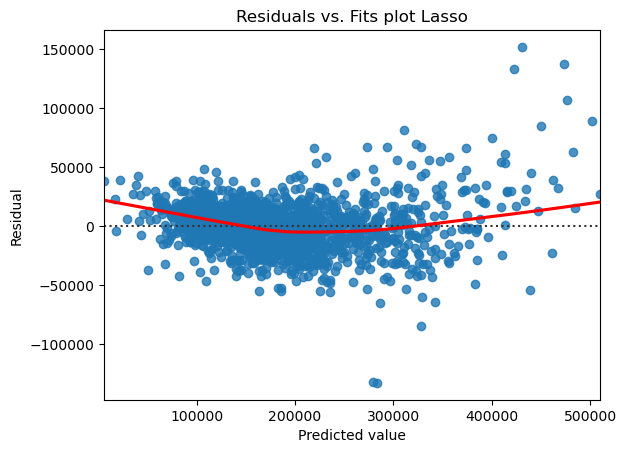

In [49]:
sns.residplot(x = l_preds,
              y = l_resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot Lasso',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

Using the Lasso method of regularlization is increasing the homoscedasticity.  The errors are starting to flatten out as you can tell by the line drawn on this plot.  The dispersion of the residuals may have a similar shape to previous models but the spread is much tighter.

Checking residual/error normality

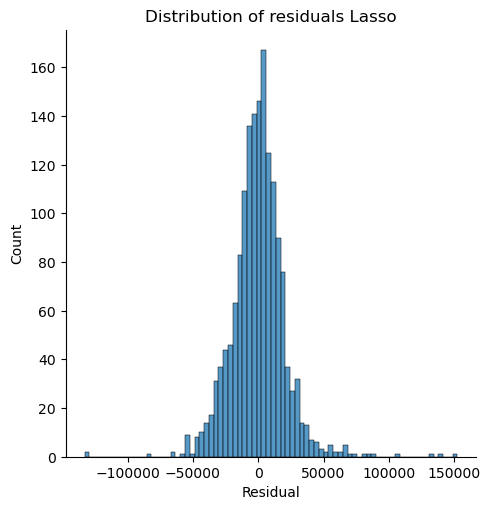

In [50]:
sns.displot(l_resid)\
    .set(title = 'Distribution of residuals Lasso',
        xlabel = 'Residual');

The residuals continue to approach a more normal distribution. It still appears that there is a right skew to this distribution due to the higher range of errors in the positive direction.  

Q-Q plot

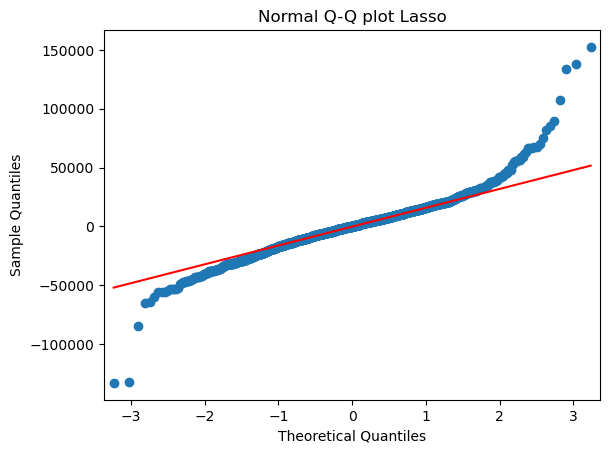

In [51]:
sm.qqplot(l_resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot Lasso');

The residuals aren't falling along the normal distribution very well here.

### Ridge Model

Like the lasso method we used above, we will use our transformed and scaled data and the RidgeCV model to determine the best alpha value.  The Ridge method also penalizes coefficients to prevent overfitting.  The alpha value is the strength of the penalty imposed.

In [52]:
ridge = RidgeCV(alphas = np.logspace(0, 5, 100))

#fit to scaled data
ridge.fit(X_train_tx, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]))

In [53]:
# what is the best alpha?
ridge.alpha_

2.8480358684358014

#### Model Evaluation
In this section we will:
- Obtain the cross validation score to inform what the expected scores should be for our model on training and validation data  
- Score the model using training data getting both R2 and RMSE
- Score the model using validation data getting both R2 and RMSE
- Make predictions with the model and calculate the residuals
- Plot the residuals against the predicted values to help evaluate the model
- Check the distribution of the errors
- Generate a Q-Q plot to check normality

Cross validation score

In [54]:
# check cross val score
cross_val_score(ridge, X_train_tx, y_train, cv=5).mean()

0.9102429958793191

Score the model on training data

In [55]:
# ridge train score
get_scores(y_train, ridge.predict(X_train_tx))

('R2 score: 0.93', 'RMSE: 20834.37')

Score the model on validation data

In [56]:
# ridge val score
get_scores(y_val, ridge.predict(X_val_tx))

('R2 score: 0.91', 'RMSE: 22462.56')

Using the ridge regularlization, the R2 scores are almost idential to the lasso, however the cross validation score is slightly higher for the ridge.  The RMSE ticked down slightly, by about 100 dollars.

Make predictions using the ridge model and calculate the residuals

In [57]:
#calculate residuals by creating predictions
r_preds = ridge.predict(X_train_tx)
r_resid = y_train - r_preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

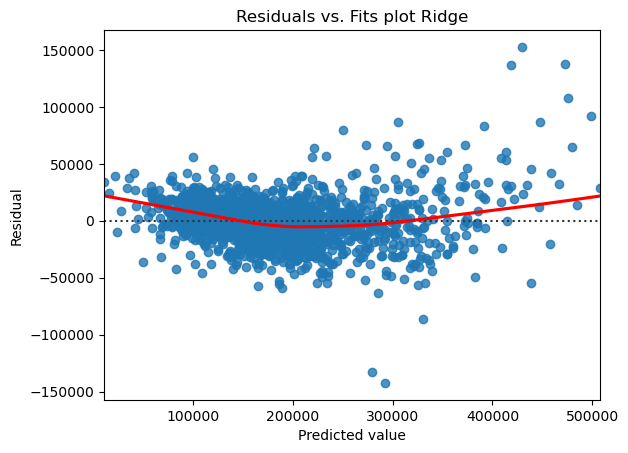

In [58]:
sns.residplot(x = r_preds,
              y = r_resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot Ridge',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

Similar to what we saw with lasso, the dispersion is much tighter to 0 overall, but there is still some variance as the predicted value increases.

Checking residual/error normality

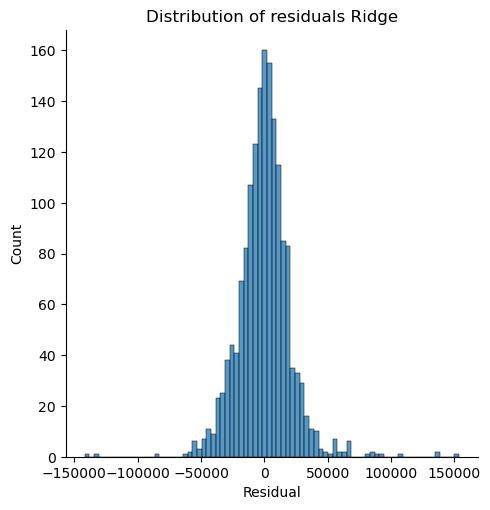

In [59]:
sns.displot(r_resid)\
    .set(title = 'Distribution of residuals Ridge',
        xlabel = 'Residual');

This distribution is very close to normally distributed with symmetry.

Q-Q plot

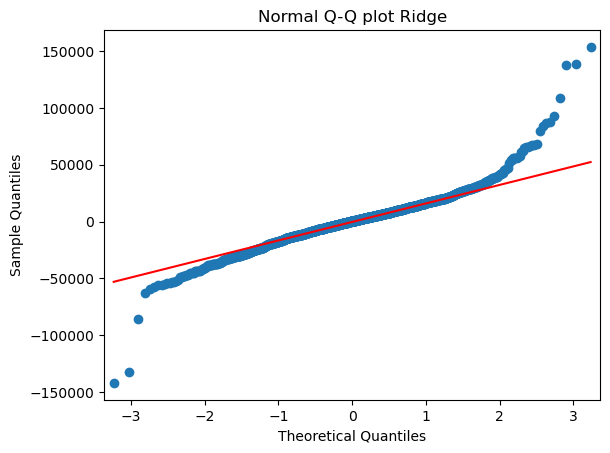

In [60]:
sm.qqplot(r_resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot Ridge');

These residuals are fitting the normal distribution line better than the lasso model, but still have divergence at the higher and lower quantiles.

### Elastic Net

Elastic Net regularization uses the penalties from both the lasso and the ridge methods, so it is a mixture of the two methodologies. Similarly we will fit the transformed and scaled data.

In [61]:
enet = ElasticNetCV(alphas=np.arange(0.001, 1.0, 0.005))

#fit to scaled data
enet.fit(X_train_tx, y_train)

ElasticNetCV(alphas=array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096, 0.101, 0.106, 0.111, 0.116, 0.121, 0.126, 0.131,
       0.136, 0.141, 0.146, 0.151, 0.156, 0.161, 0.166, 0.171, 0.176,
       0.181, 0.186, 0.191, 0.196, 0.201, 0.206, 0.211, 0.216, 0.221,
       0.226, 0.231, 0.236, 0.241, 0.246, 0.251, 0.256, 0.261, 0.266...
       0.676, 0.681, 0.686, 0.691, 0.696, 0.701, 0.706, 0.711, 0.716,
       0.721, 0.726, 0.731, 0.736, 0.741, 0.746, 0.751, 0.756, 0.761,
       0.766, 0.771, 0.776, 0.781, 0.786, 0.791, 0.796, 0.801, 0.806,
       0.811, 0.816, 0.821, 0.826, 0.831, 0.836, 0.841, 0.846, 0.851,
       0.856, 0.861, 0.866, 0.871, 0.876, 0.881, 0.886, 0.891, 0.896,
       0.901, 0.906, 0.911, 0.916, 0.921, 0.926, 0.931, 0.936, 0.941,
       0.946, 0.951, 0.956, 0.961, 0.966, 0.971, 0.976, 0.981, 0.986,
       0.991, 0.996]))

In [62]:
# what is the best alpha?
enet.alpha_

0.006

#### Model Evaluation
In this section we will:
- Obtain the cross validation score to inform what the expected scores should be for our model on training and validation data  
- Score the model using training data getting both R2 and RMSE
- Score the model using validation data getting both R2 and RMSE
- Make predictions with the model and calculate the residuals
- Plot the residuals against the predicted values to help evaluate the model
- Check the distribution of the errors
- Generate a Q-Q plot to check normality

Cross validation score

In [63]:
# check cross val score
cross_val_score(enet, X_train_tx, y_train, cv=5).mean()

0.9107934267304852

Score the model on training data

In [64]:
# elastic net train score
get_scores(y_train, enet.predict(X_train_tx))

('R2 score: 0.93', 'RMSE: 21029.16')

Score the model on validation data

In [65]:
# elastic net val score
get_scores(y_val, enet.predict(X_val_tx))

('R2 score: 0.91', 'RMSE: 22443.35')

Using Elastic Net, we get similar R2 scores as both the lasso and ridge methods.  The RMSE only lowered by about 20 dollars, but still an improvement.

Make predictions using the elastic net model and calculate the residuals

In [66]:
#calculate residuals by creating predictions
e_preds = enet.predict(X_train_tx)
e_resid = y_train - e_preds

Create a "residuals vs. fits" plot to visualize to show our predictions against our errors (residuals)

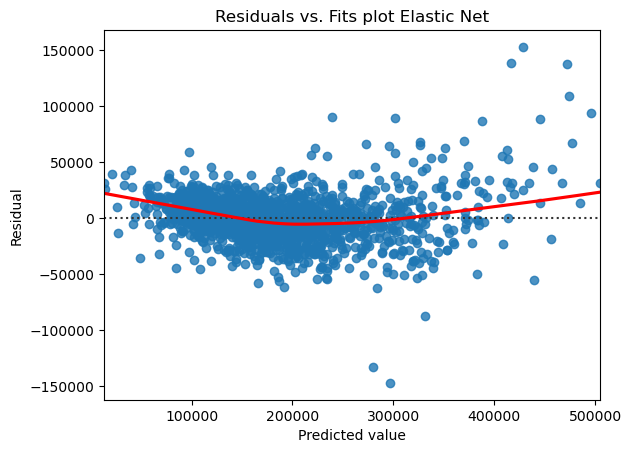

In [67]:
sns.residplot(x = e_preds,
              y = e_resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot Elastic Net',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

Similar to what we saw with lasso and ridge, the dispersion is much tighter to 0 overall, but there is still some variance as the predicted value increases.

Checking residual/error normality

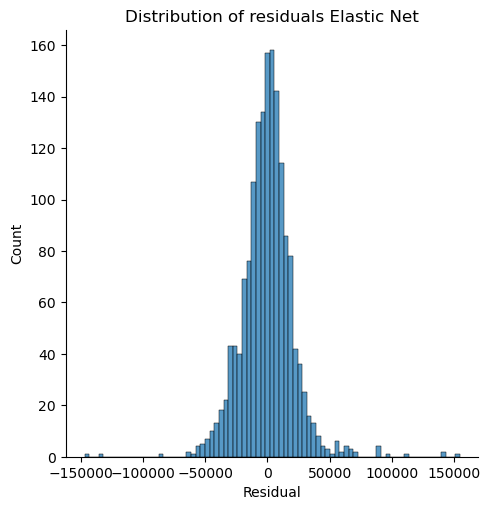

In [68]:
sns.displot(e_resid)\
    .set(title = 'Distribution of residuals Elastic Net',
        xlabel = 'Residual');

Similar to the ridge, this looks close to normally distributed with good symmetry.

Q-Q plot

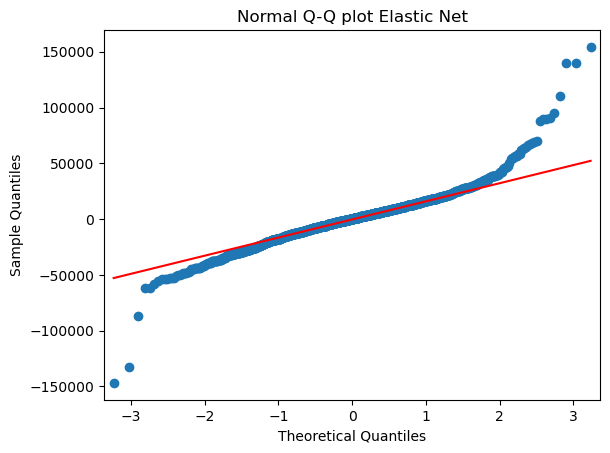

In [69]:
sm.qqplot(e_resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot Elastic Net');

This q-q plot is also very similar to the ridge plot.  Many residuals are falling on the normal distrbution line, but start to diverge around the +/- 2 quantile.

### Kaggle Submission

- Second submission was based on a ridge model, but was from a prior data cleaning and EDA attempt.
- Third attempt will probably be my final and based on the above Elastic Net.  I believe this scored slightly better.

In [70]:
#stash id
test_id = test['id']

Transform the test values in the same way I transformed the train and test values.

In [71]:
#transform val
Xtx_test = ctx.transform(test.drop(columns='id'))

Re-create the dataframe

In [72]:
#recreate dataframe
Xtx_test = pd.DataFrame(Xtx_test, columns=ctx.get_feature_names_out())

Instantiate a new model using the best alpha that was determined above.

In [73]:
# instantiate model with best alpha from above
# ridge_sub = Ridge(alpha=ridge.alpha_)

enet_sub = ElasticNet(alpha=enet.alpha_)

Fit the model with the training data.

In [74]:
# submission 2
# ridge_sub.fit(X_train_tx, y_train)

# submission 3
enet_sub.fit(X_train_tx, y_train)

ElasticNet(alpha=0.006)

Create predictions

In [75]:
# make predictions
# preds = ridge_sub.predict(Xtx_test)

preds = enet_sub.predict(Xtx_test)

In [76]:
preds.shape

(878,)

Construct the DataFrame with the predictions.

In [77]:
preds = pd.DataFrame(preds, columns=['SalePrice'])

Insert the Ids that were "stashed" earlier

In [78]:
preds.insert(loc=0, column='Id', value=test_id)

In [79]:
preds

,Id,SalePrice
0,2658,138756.830488
1,2718,156094.960629
2,2414,218033.183323
3,1989,101362.743572
4,625,175797.317063
...,...,...
873,1662,182013.747449
874,1234,221498.861572
875,1373,127139.220662
876,1672,104200.920869


Save the csv file(s) for submission to Kaggle.

In [80]:
# save submission csv and get on that leaderboard
# enet 1 used alpha of .001
# enet 2 used alpha of .006
preds.to_csv('../data/enet_2.csv', index=False)

#think about making a function that can display all your scores 
# and save scores to dataframe so you can refer back to it